In [1]:
import torch

import matplotlib.pyplot as plt
import os 
from pathlib import Path

# Changing the directory to the main directory in the docker image
main_path = '/workspaces/ssa-solvers' 
os.chdir(main_path) # project directory

%load_ext line_profiler
%matplotlib inline

torch.set_default_tensor_type(torch.FloatTensor) # no need for double precision 
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device("cpu")


In [2]:
from ssa_solvers.simulators import StochasticSimulator, DeterministicSimulator 

end_time = 400
n_steps = 150 # recommend using 150 - 200 points
n_traj = 1000
time_grid = torch.arange(0, end_time, int(end_time / n_steps), device=device)


### Simulating in cis TetR autorepressor with sRNA  circuit

In [3]:
from circuits.auto_repressor.tetr_srna_incis import TetRsRNAInCis, cfg

reaction_system_incis = TetRsRNAInCis(device=device)
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system_incis,
    cfg=cfg
)
ssa_simulator_incis = StochasticSimulator(
    reaction_system=reaction_system_incis,
    cfg=cfg,
    device=device
)
reaction_system_incis.params = {'aTc': 100}  # setting aTc level
init_pops = torch.zeros((reaction_system_incis.n_species, ), dtype=torch.int64, device=device) 
ssa_simulator_incis.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
ode_res_incis = ode_simulator.simulate(init_pops=init_pops, time_grid=time_grid)

### Simulating in trans TetR autorepressor with sRNA  circuit

In [4]:
from circuits.auto_repressor.tetr_srna_intrans import TetRsRNAInTrans, cfg
reaction_system_intrans = TetRsRNAInTrans(device=device)

ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system_intrans,
    cfg=cfg
)
ssa_simulator_intrans = StochasticSimulator(
    reaction_system=reaction_system_intrans,
    cfg=cfg,
    device=device
)
reaction_system_intrans.params = {'aTc': 100}  # setting aTc level
init_pops = torch.zeros((reaction_system_intrans.n_species, ), dtype=torch.int64, device=device) #torch.randint(1, (reaction_system.n_species, ))
ssa_simulator_intrans.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
ode_res_intrans = ode_simulator.simulate(init_pops=init_pops, time_grid=time_grid)

### Comptuting the statistics on a grid

In [5]:
means_incis, stds_incis = ssa_simulator_incis.data_set.mean_and_std(time_grid=time_grid)

means_intrans, stds_intrans = ssa_simulator_intrans.data_set.mean_and_std(time_grid=time_grid)

### Plotting results

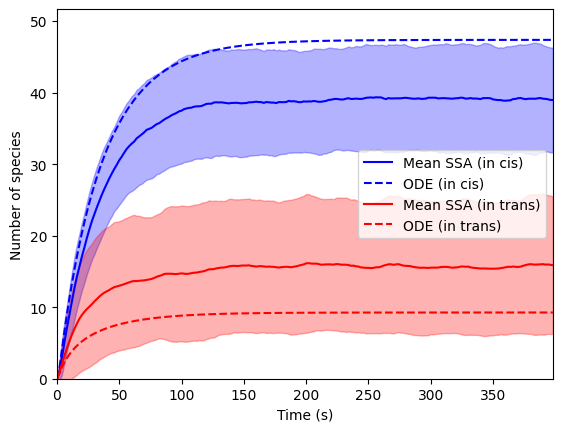

In [6]:
time_grid = time_grid.cpu()

species_idx_incis = 1
plt.figure()
plt.plot(time_grid, means_incis[species_idx_incis, :], 'b', label='Mean SSA (in cis)')
plt.fill_between(time_grid, means_incis[species_idx_incis,:]+stds_incis[species_idx_incis, :], means_incis[species_idx_incis,:]-stds_incis[species_idx_incis, :], 
                 color='b', alpha=0.3)
plt.xlim([0, end_time])    
plt.plot(time_grid, ode_res_incis[species_idx_incis, :], 'b--', label='ODE (in cis)')
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
# random traces 
# trajs = [0, 40, 20, 11]
# for traj_idx in trajs:
#     plt.plot(data_set.raw_times_trajectories[traj_idx,  :], data_set.raw_pops_trajectories[traj_idx, species_idx, :], color='b')

species_idx_intrans = 2
plt.plot(time_grid, means_intrans[species_idx_intrans, :], 'r', label='Mean SSA (in trans)')
plt.fill_between(time_grid, means_intrans[species_idx_intrans,:]+stds_intrans[species_idx_intrans, :], means_intrans[species_idx_intrans,:]-stds_intrans[species_idx_intrans, :], 
                 color='r',alpha=0.3)
plt.xlim([0, end_time])    
plt.plot(time_grid, ode_res_intrans[species_idx_intrans, :], 'r--', label='ODE (in trans)')
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
plt.xlim([0, max(time_grid)])
plt.ylim([0, 1.1 * max([(means_intrans[species_idx_intrans,:]+stds_intrans[species_idx_intrans, :]).max(), 
                        (means_incis[species_idx_incis,:]+stds_incis[species_idx_incis, :]).max()])])
plt.legend()


### Computing coefficient of variation on a grid 

In [7]:
atc_grid = [0, 1, 10, 20, 100, 200, 1000]
cov_incis = []
cov_intrans = []
mean_incis = []
mean_intrans = []

time_grid = torch.as_tensor([time_grid[-1]], device=device)
for atc in atc_grid:
    init_pops = torch.zeros((reaction_system_incis.n_species, ), dtype=torch.int64, device=device) 
    ssa_simulator_incis.set_reaction_params({'aTc': atc, 'k_rep': 5})
    ssa_simulator_incis.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
    _mean_incis, _std_incis = ssa_simulator_incis.data_set.mean_and_std(time_grid=time_grid)
    mean_incis.append(_mean_incis)
    cov_incis.append(_std_incis / _mean_incis)
    
    init_pops = torch.zeros((reaction_system_intrans.n_species, ), dtype=torch.int64, device=device) 
    ssa_simulator_intrans.set_reaction_params({'aTc': atc, 'k_rep': 5})
    ssa_simulator_intrans.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
    _mean_intrans, _std_intrans = ssa_simulator_intrans.data_set.mean_and_std(time_grid=time_grid)
    mean_intrans.append(_mean_intrans)
    cov_intrans.append(_std_intrans /_mean_intrans)

### Plotting coefficient of variation

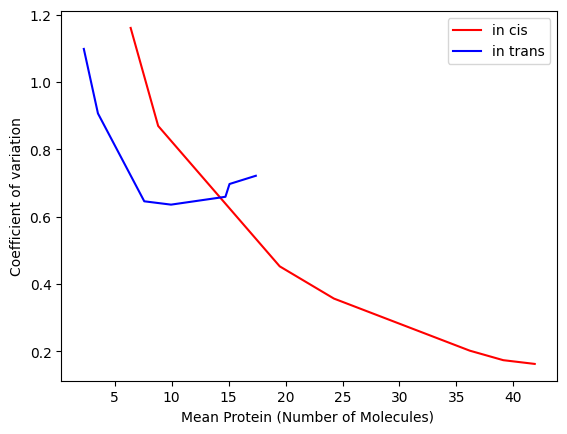

In [8]:
species_idx_incis = 1
species_idx_intrans = 2

plt.figure()
plt.plot(torch.stack(mean_incis)[:, species_idx_incis, :], 
         torch.stack(cov_incis)[:, species_idx_incis, :], 'r', label='in cis' )
plt.plot(torch.stack(mean_intrans)[:, species_idx_intrans, :], 
         torch.stack(cov_intrans)[:, species_idx_intrans, :], 'b', label='in trans')
plt.xlabel('Mean Protein (Number of Molecules) ')
plt.ylabel('Coefficient of variation')
plt.legend()